In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip uninstall -q transformers -y
! pip uninstall -q torch -y

In [ ]:
! pip install -q transformers==4.39.3
! pip install -q torchvision==0.16.0
! pip install -q torchaudio==2.1.0
! pip install -q torch==2.1.0

In [1]:
import shutil
import os
from tqdm import tqdm

# Define source and destination directories
source_dir = "/kaggle/input/bert-final"
destination_dir = "/kaggle/working/checkpoints_pytorch/bert_final/level_1/"

# Create destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Create destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Check if source directory exists
if os.path.exists(source_dir):
    # Get the total number of items to track progress
    total_items = sum([len(files) for r, d, files in os.walk(source_dir)])
    
    # Initialize tqdm progress bar
    progress_bar = tqdm(total=total_items, desc='Moving files and folders')

    # Iterate over each item in the source directory
    for root, dirs, files in os.walk(source_dir):
        for item in files + dirs:
            source_item_path = os.path.join(root, item)
            destination_item_path = os.path.join(destination_dir, os.path.relpath(source_item_path, source_dir))

            # Copy the item to the destination directory
            shutil.copy(source_item_path, destination_item_path)
            
            # Update tqdm progress bar
            progress_bar.update(1)

    # Close tqdm progress bar
    progress_bar.close()

    print("Folders and their content copied successfully!")
else:
    print(f"Source directory '{source_dir}' does not exist.")


Moving files and folders: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

Folders and their content copied successfully!


In [80]:
import os
os.chdir('/kaggle/input')

In [4]:
import torch
# import torchinfo
# from torchvision.models import resnet50
from torch.utils.data import DataLoader

import pandas as pd
from dataloader.level_1_dataloader import text_dataloader
from model9.level_1_classifier import level_1_classifier, level_1_model, level_1_output_layer
from model9.level_2_classifier import level_2_classifier, level_2_output_layer, level_2_pre_model_concate, level_2_post_model
from config15.Trainer import Trainer_level_1, Trainer_level_2
from config15.Tester import Tester_level_1, Tester_level_2
# from transformers import XLNetTokenizer, XLNetModel
# from transformers import DistilBertTokenizer, DistilBertModel
# from transformers import RobertaTokenizer, RobertaModel
# from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, CLIPModel, CLIPTextModel

2024-06-01 12:17:25.259147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 12:17:25.259251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 12:17:25.376296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def read_csv(root_dir, csv_file):
    # csv_path = os.path.join(root_dir, csv_file)
    df = pd.read_csv(csv_file)

    data = []
    level_1_label = []
    level_2_label = []
    for ind in df.index:
        desc = df['description'][ind]
        desc_file = os.path.join(root_dir, desc)
        with open(desc_file, 'r', encoding='utf-8') as file:
            text = file.read()
            data.append(text)
        level_1_label.append(df['fiction_nonfiction'][ind])
        level_2_label.append(df['categories'][ind])
    return data, level_1_label, level_2_label


In [6]:
os.getcwd()

'/kaggle/input'

In [ ]:
train_x, train_y, train_y2 = read_csv(csv_file = '/kaggle/input/csv-files-data/train_set.csv', root_dir = '/kaggle/input/classification-dataset-iiti/description/description')
val_x, val_y, val_y2 = read_csv(csv_file = '/kaggle/input/csv-files-data/val_set.csv', root_dir = '/kaggle/input/classification-dataset-iiti/description/description')
test_x, test_y, test_y2 = read_csv(csv_file = '/kaggle/input/csv-files-data/test_set.csv', root_dir = '/kaggle/input/classification-dataset-iiti/description/description')

In [ ]:
print('no. of training sample',len(train_x), len(train_y))
print('no. of validation sample',len(val_x),len(val_y))
print('no. of testing sample',len(test_x),len(test_y))

In [ ]:
def assign_gpu_model(model):
    print("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

In [ ]:
os.chdir('/kaggle/working')

In [ ]:
version = 'xlnet-base-cased'
max_length = 120
tokenizer = XLNetTokenizer.from_pretrained(version)
# tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = version)

In [ ]:
# For CLIP Model
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
tokenizer

In [ ]:

version = 'distilbert-base-uncased'
max_length = 120
tokenizer = DistilBertTokenizer.from_pretrained(version)

In [10]:

version = 'bert-base-uncased'
max_length = 120
tokenizer = BertTokenizerFast.from_pretrained(version)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Filtering of dataset for the 2nd level

In [11]:
import re
# filtering the dataset for level 2 - removing the data files having words < 20
def filter_dataset(sentences, level_1_labels, level_2_labels):
    new_data_x = []
    new_data_y = []
    new_data_y2 = []
    for idx, sentence in enumerate(sentences):
        
        # Use regular expression to split the sentence into words
        words = re.findall(r'\b\w+\b', sentence)
        word_count = len(words)
        if word_count > 20:
            new_data_x.append(sentence)
            new_data_y.append(level_1_labels[idx])
            new_data_y2.append(level_2_labels[idx])
    return new_data_x, new_data_y, new_data_y2    

In [12]:
# for train dataset
train_x, train_y, train_y2 = filter_dataset(train_x, train_y, train_y2)

In [13]:
# for test dataset
test_x, test_y, test_y2 = filter_dataset(test_x, test_y, test_y2)

In [14]:
# for val dataset
val_x, val_y, val_y2 = filter_dataset(val_x, val_y, val_y2)

In [16]:
import nltk

# Download required nltk data files
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# code to do dataset preprocessing using nltk library for removing stopwords, articles, punctuation 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import string

# Define a function for text preprocessing
def preprocess_text(data):
    temp_list = []
    for texts in data:
        # Tokenize text into sentences
        sentences = sent_tokenize(texts)

        # Define stopwords and add articles
        stop_words = set(stopwords.words('english'))
        articles = set(['a', 'an', 'the'])
        stop_words = stop_words.union(articles)

        # Punctuation to be removed
        punctuation = string.punctuation

        processed_text = []

        for sentence in sentences:
            # Tokenize each sentence into words
            words = word_tokenize(sentence)

            # Remove stopwords and punctuation, and convert to lower case
            filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word not in punctuation]

            # Reconstruct the sentence
            processed_sentence = ' '.join(filtered_words)
            processed_text.append(processed_sentence)
    
        temp_list.append(' '.join(processed_text))
    return temp_list

In [20]:
# Preprocess the validation texts
val_x = preprocess_text(val_x)
len(val_x)

2646

In [23]:
len(train_x)

20920

In [22]:
# Preprocess the training texts
train_x = preprocess_text(train_x)
len(train_x)

20920

In [ ]:
len(train_y2)

In [15]:
def get_embedding(data, encoder):
    encoding = encoder(
          text = data,
          add_special_tokens = True,
          max_length = max_length,
          truncation = True,
          padding = True,
          return_tensors = 'pt',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
    return encoding

In [16]:
train_x = get_embedding(train_x,tokenizer)
val_x = get_embedding(val_x,tokenizer)
test_x = get_embedding(test_x,tokenizer)

In [17]:
print(type(train_x))
print(train_x.keys())

<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'attention_mask'])


In [18]:
train_x = torch.tensor(train_x['input_ids'], dtype=torch.long)
val_x = torch.tensor(val_x['input_ids'], dtype=torch.long)
test_x = torch.tensor(test_x['input_ids'], dtype=torch.long)

/tmp/ipykernel_34/2271462325.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x['input_ids'], dtype=torch.long)
/tmp/ipykernel_34/2271462325.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_x = torch.tensor(val_x['input_ids'], dtype=torch.long)
/tmp/ipykernel_34/2271462325.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x = torch.tensor(test_x['input_ids'], dtype=torch.long)


In [ ]:
train_x

In [19]:
train_set = text_dataloader(embeddings = train_x, level_1_labels = train_y, level_2_labels = train_y2, model_name='bert')
val_set = text_dataloader(embeddings = val_x, level_1_labels = val_y, level_2_labels = val_y2, model_name='bert')
test_set = text_dataloader(embeddings = test_x, level_1_labels = test_y, level_2_labels = test_y2, model_name='bert')

In [20]:

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
print(len(train_dataloader))

val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
print(len(val_dataloader))

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)
print(len(test_dataloader))

654
83
83


In [21]:
def fine_tune_load_model():
    model = BertModel.from_pretrained(version, return_dict=False)
    print(model.modules)
    
    for p in model.parameters():
        p.requires_grad = True
    

    return model


In [22]:
FE_model = fine_tune_load_model()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<bound method Module.modules of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): 

In [23]:
import os

used_model = 'bert_final'
used_model_feature_size = 768
level_1_checkpoint_dir = '/kaggle/working/checkpoints_pytorch/'+used_model+'/level_1/'
level_1_model_file = 'model.pth'
level_1_csvlogger_file = 'log.csv'
level_1_weights_path = os.path.join(level_1_checkpoint_dir, level_1_model_file)
feature_size_extract_from_level_1 = 64
no_epoch = 50
lr = 0.001
optimizer = 'Adadelta'

# Check if level_1_checkpoint_dir exists, if not, create it
if not os.path.exists(level_1_checkpoint_dir):
    os.makedirs(level_1_checkpoint_dir)


In [24]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1, model_name = 'bert')
model_level_1 = assign_gpu_model(model_level_1)

cuda


In [25]:
trainer = Trainer_level_1(model = model_level_1, level=1, training_dataloader = train_dataloader, validation_dataloader = val_dataloader, epoch = no_epoch, learning_rate = lr, use_gpu = True, opt_method = optimizer, checkpoint_dir = level_1_checkpoint_dir, checkpoint_filename=level_1_model_file, csv_logger = level_1_csvlogger_file  )

Epochwise level 1 weights loaded


Finish initializing...
2024-05-21 13:45:59.350897
EPOCH 1:


  0%|          | 0/654 [00:00<?, ?batch/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.696]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/kaggle/input/config15/Trainer.py:261: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


LOSS train 0.6939123154415632, train_precision_0.4902097902097902, train_recall_0.06364626838569094, train_f1 0.1126647380263581, train_acc_0.4721797323135755, train_ba_0.49502725290877525, train_spec_0.9264082374318595, train_hm_0.5278202676864244, val_loss 0.6937212944030762, val_precision_nan, val_recall_0.0, val_f1 nan, val_acc_0.4474678760393046, val_ba_0.5, val_spec_1.0, val_hm_0.5525321239606954
model saved on epoch_0
model level 1 latest epoch saved on epoch_0
2024-05-21 13:50:02.709456
EPOCH 2:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.694]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6932476491009424, train_precision_0.5265486725663717, train_recall_0.3889595060831669, train_f1 0.44741514360313317, train_acc_0.49416826003824094, train_ba_0.5000521334171134, train_spec_0.61114476075106, train_hm_0.5058317399617591, val_loss 0.6926428079605103, val_precision_0.5479345284489477, val_recall_0.9616963064295485, val_f1 0.6981132075471698, val_acc_0.5404383975812547, val_ba_0.4909832883499094, val_spec_0.02027027027027027, val_hm_0.4595616024187453
model saved on epoch_1
model level 1 latest epoch saved on epoch_1
2024-05-21 13:54:05.793964
EPOCH 3:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.695]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6926075128969431, train_precision_0.5327828138581895, train_recall_0.7790993281278373, train_f1 0.6328171091445428, train_acc_0.5239961759082218, train_ba_0.5097293531412456, train_spec_0.24035937815465375, train_hm_0.4760038240917782, val_loss 0.6916258931159973, val_precision_0.5516717325227963, val_recall_0.9931600547195623, val_f1 0.7093307278944797, val_acc_0.5502645502645502, val_ba_0.49826921654897033, val_spec_0.0033783783783783786, val_hm_0.4497354497354497
model saved on epoch_2
model level 1 latest epoch saved on epoch_2
2024-05-21 13:58:08.681619
EPOCH 4:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.698]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6921998485694967, train_precision_0.5288327750579748, train_recall_0.9317232613037951, train_f1 0.6747098852690752, train_acc_0.5270076481835564, train_ba_0.5043736435733593, train_spec_0.07702402584292348, train_hm_0.4729923518164436, val_loss 0.690642237663269, val_precision_0.5518939393939394, val_recall_0.9965800273597811, val_f1 0.7103851779619696, val_acc_0.5510204081632653, val_ba_0.4987123109771879, val_spec_0.0008445945945945946, val_hm_0.4489795918367347
model saved on epoch_3
model level 1 latest epoch saved on epoch_3
2024-05-21 14:02:11.593433
EPOCH 5:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.696]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6914454817954189, train_precision_0.5281955808142668, train_recall_0.9788451062284366, train_f1 0.6861416070007954, train_acc_0.5285372848948374, train_ba_0.5033535040530432, train_spec_0.02786190187764991, train_hm_0.4714627151051625, val_loss 0.6894391775131226, val_precision_0.552571860816944, val_recall_0.9993160054719562, val_f1 0.7116415002435459, val_acc_0.5525321239606954, val_ba_0.5000803000332754, val_spec_0.0008445945945945946, val_hm_0.4474678760393046
model saved on epoch_4
model level 1 latest epoch saved on epoch_4
2024-05-21 14:06:14.446348
EPOCH 6:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.682]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6903010756233052, train_precision_0.5285741960480433, train_recall_0.9909206464499728, train_f1 0.6894068599583096, train_acc_0.529923518164436, train_ba_0.5041419303317903, train_spec_0.017363214213607914, train_hm_0.47007648183556405, val_loss 0.6873807907104492, val_precision_0.5529500756429652, val_recall_1.0, val_f1 0.7121285923039453, val_acc_0.5532879818594104, val_ba_0.5008445945945946, val_spec_0.0016891891891891893, val_hm_0.4467120181405896
model saved on epoch_5
model level 1 latest epoch saved on epoch_5
2024-05-21 14:10:17.260995
EPOCH 7:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.674]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6873165335312531, train_precision_0.5363882729736388, train_recall_0.9883784274559652, train_f1 0.6953911016001788, train_acc_0.5441204588910133, train_ba_0.5192750203098522, train_spec_0.05017161316373915, train_hm_0.4558795411089866, val_loss 0.6804230809211731, val_precision_0.5718265021886192, val_recall_0.9829001367989056, val_f1 0.7230188679245283, val_acc_0.5839002267573696, val_ba_0.5370581765075609, val_spec_0.09121621621621621, val_hm_0.41609977324263037
model saved on epoch_6
model level 1 latest epoch saved on epoch_6
2024-05-21 14:14:19.856796
EPOCH 8:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.657]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6760662083232075, train_precision_0.6104975656097851, train_recall_0.9335391320138006, train_f1 0.738225157955198, train_acc_0.651434034416826, train_ba_0.6356571089101912, train_spec_0.3377750858065819, train_hm_0.348565965583174, val_loss 0.6600444912910461, val_precision_0.7393284006829823, val_recall_0.8885088919288646, val_f1 0.8070829450139795, val_acc_0.7653061224489796, val_ba_0.7508422838022701, val_spec_0.6131756756756757, val_hm_0.23469387755102042
model saved on epoch_7
model level 1 latest epoch saved on epoch_7
2024-05-21 14:18:22.376094
EPOCH 9:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.647]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6500869196489316, train_precision_0.7529559157466135, train_recall_0.8730706373706192, train_f1 0.8085768341391634, train_acc_0.7823613766730402, train_ba_0.7772883976273649, train_spec_0.6815061578841106, train_hm_0.21763862332695985, val_loss 0.6203052997589111, val_precision_0.821451509312781, val_recall_0.874829001367989, val_f1 0.847300430606161, val_acc_0.825774754346183, val_ba_0.8200158520353459, val_spec_0.7652027027027027, val_hm_0.17422524565381708
model saved on epoch_8
model level 1 latest epoch saved on epoch_8
2024-05-21 14:22:25.159459
EPOCH 10:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:51<00:00,  2.82batch/s, loss=0.558]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.6029808328968305, train_precision_0.8186822638912782, train_recall_0.8641728708915926, train_f1 0.8408127208480566, train_acc_0.8277246653919694, train_ba_0.8256862739275246, train_spec_0.7871996769634565, train_hm_0.1722753346080306, val_loss 0.5532262921333313, val_precision_0.8545697131420947, val_recall_0.8761969904240766, val_f1 0.8652482269503545, val_acc_0.8492063492063492, val_ba_0.8460376844012275, val_spec_0.8158783783783784, val_hm_0.15079365079365079
model saved on epoch_9
model level 1 latest epoch saved on epoch_9
2024-05-21 14:26:28.025342
EPOCH 11:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.82batch/s, loss=0.42] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.5347094096995275, train_precision_0.8631501965444739, train_recall_0.8572725621935718, train_f1 0.8602013392247072, train_acc_0.8532982791586998, train_ba_0.8530760145916375, train_spec_0.8488794669897032, train_hm_0.1467017208413002, val_loss 0.47221630811691284, val_precision_0.8962597035991532, val_recall_0.8686730506155951, val_f1 0.8822507815213616, val_acc_0.8718820861678005, val_ba_0.8722588226050949, val_spec_0.8758445945945946, val_hm_0.12811791383219956
model saved on epoch_10
model level 1 latest epoch saved on epoch_10
2024-05-21 14:30:31.147847
EPOCH 12:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.82batch/s, loss=0.431]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.4687880399303699, train_precision_0.8939683145638481, train_recall_0.8504630470310514, train_f1 0.8716731807184068, train_acc_0.8681644359464628, train_ba_0.8691543985407629, train_spec_0.8878457500504745, train_hm_0.13183556405353727, val_loss 0.4108792245388031, val_precision_0.940677966101695, val_recall_0.83515731874145, val_f1 0.8847826086956522, val_acc_0.8798185941043084, val_ba_0.8850617674788331, val_spec_0.9349662162162162, val_hm_0.12018140589569161
model saved on epoch_11
model level 1 latest epoch saved on epoch_11
2024-05-21 14:34:34.244324
EPOCH 13:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.82batch/s, loss=0.475]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.41027241963494443, train_precision_0.9124194493263035, train_recall_0.8484655892500454, train_f1 0.8792811441475349, train_acc_0.8773422562141492, train_ba_0.8789572040738416, train_spec_0.9094488188976378, train_hm_0.12265774378585086, val_loss 0.3500196039676666, val_precision_0.9314868804664723, val_recall_0.8741450068399452, val_f1 0.9019054340155257, val_acc_0.8949357520786092, val_ba_0.8973765574740267, val_spec_0.9206081081081081, val_hm_0.10506424792139078
model saved on epoch_12
model level 1 latest epoch saved on epoch_12
2024-05-21 14:38:37.423127
EPOCH 14:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.82batch/s, loss=0.382]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.3465582784436165, train_precision_0.9151178386664112, train_recall_0.8672598510986018, train_f1 0.8905463360059668, train_acc_0.8877629063097514, train_ba_0.8889095540572759, train_spec_0.91055925701595, train_hm_0.11223709369024856, val_loss 0.28840577602386475, val_precision_0.9212543554006969, val_recall_0.9042407660738714, val_f1 0.9126682775284777, val_acc_0.9043839758125473, val_ba_0.9044007884423411, val_spec_0.9045608108108109, val_hm_0.09561602418745276
model saved on epoch_13
model level 1 latest epoch saved on epoch_13
2024-05-21 14:42:40.528571
EPOCH 15:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.82batch/s, loss=0.169]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.28764660912779494, train_precision_0.9189847335393837, train_recall_0.8908661703286725, train_f1 0.9047070213452584, train_acc_0.9011950286806883, train_ba_0.9017726773307001, train_spec_0.9126791843327277, train_hm_0.09880497131931167, val_loss 0.2488332837820053, val_precision_0.9320113314447592, val_recall_0.9001367989056087, val_f1 0.9157967988865693, val_acc_0.90854119425548, val_ba_0.9095278589122638, val_spec_0.918918918918919, val_hm_0.09145880574452003
model saved on epoch_14
model level 1 latest epoch saved on epoch_14
2024-05-21 14:46:43.670797
EPOCH 16:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.268] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.25289536048786354, train_precision_0.9204955163169086, train_recall_0.9040312329762121, train_f1 0.9121890889102653, train_acc_0.9083652007648183, train_ba_0.9086075809540863, train_spec_0.9131839289319604, train_hm_0.09163479923518164, val_loss 0.2264113575220108, val_precision_0.9321329639889196, val_recall_0.920656634746922, val_f1 0.9263592567102547, val_acc_0.9191232048374905, val_ba_0.9189431822383258, val_spec_0.9172297297297297, val_hm_0.08087679516250945
model saved on epoch_15
model level 1 latest epoch saved on epoch_15
2024-05-21 14:50:47.198567
EPOCH 17:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.304] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.22760407061569551, train_precision_0.9237704918032786, train_recall_0.9209188305792627, train_f1 0.9223424570337364, train_acc_0.9183556405353729, train_ba_0.9182122923338469, train_spec_0.9155057540884313, train_hm_0.08164435946462716, val_loss 0.21297810971736908, val_precision_0.9340659340659341, val_recall_0.9302325581395349, val_f1 0.932145305003427, val_acc_0.9251700680272109, val_ba_0.9245757385292269, val_spec_0.918918918918919, val_hm_0.07482993197278912
model saved on epoch_16
model level 1 latest epoch saved on epoch_16
2024-05-21 14:54:50.875211
EPOCH 18:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.145] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.20757315195641204, train_precision_0.9276429415507681, train_recall_0.9265480297802796, train_f1 0.92709516238928, train_acc_0.9232791586998088, train_ba_0.9230963447912099, train_spec_0.9196446598021402, train_hm_0.0767208413001912, val_loss 0.20633567869663239, val_precision_0.9419174247725682, val_recall_0.920656634746922, val_f1 0.9311656866136286, val_acc_0.9247921390778534, val_ba_0.9252776416977854, val_spec_0.9298986486486487, val_hm_0.07520786092214664
model saved on epoch_17
model level 1 latest epoch saved on epoch_17
2024-05-21 14:58:54.571498
EPOCH 19:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.142] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.19418319960663077, train_precision_0.9325353645266594, train_recall_0.9337207190848011, train_f1 0.9331276653661192, train_acc_0.9295411089866157, train_ba_0.9293073613594811, train_spec_0.9248940036341611, train_hm_0.07045889101338432, val_loss 0.20107783377170563, val_precision_0.9412997903563941, val_recall_0.9213406292749658, val_f1 0.9312132734185966, val_acc_0.9247921390778534, val_ba_0.92519734166451, val_spec_0.9290540540540541, val_hm_0.07520786092214664
model saved on epoch_18
model level 1 latest epoch saved on epoch_18
2024-05-21 15:02:58.310794
EPOCH 20:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.346] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.17722597750706956, train_precision_0.9380930863081789, train_recall_0.9424368984928273, train_f1 0.9402599755423705, train_acc_0.9369502868068834, train_ba_0.9366434441989677, train_spec_0.930849989905108, train_hm_0.06304971319311664, val_loss 0.19979168474674225, val_precision_0.9501779359430605, val_recall_0.9131326949384405, val_f1 0.9312870596442275, val_acc_0.9255479969765684, val_ba_0.9270055366584095, val_spec_0.9408783783783784, val_hm_0.07445200302343159
model saved on epoch_19
model level 1 latest epoch saved on epoch_19
2024-05-21 15:07:02.092021
EPOCH 21:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.121] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.16495065502708475, train_precision_0.942795076031861, train_recall_0.9457054657708371, train_f1 0.9442480282839272, train_acc_0.9412045889101338, train_ba_0.9409528742139064, train_spec_0.9362002826569755, train_hm_0.058795411089866155, val_loss 0.1836240589618683, val_precision_0.9477351916376306, val_recall_0.9302325581395349, val_f1 0.9389023127373144, val_acc_0.9331065759637188, val_ba_0.9334439817724701, val_spec_0.9366554054054054, val_hm_0.06689342403628118
model saved on epoch_20
model level 1 latest epoch saved on epoch_20
2024-05-21 15:11:05.819436
EPOCH 22:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.0309]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.15394460008869842, train_precision_0.9486970684039088, train_recall_0.9519702197203559, train_f1 0.9503308257047041, train_acc_0.9476099426386233, train_ba_0.9473660910836789, train_spec_0.9427619624470018, train_hm_0.052390057361376675, val_loss 0.1845552921295166, val_precision_0.9508426966292135, val_recall_0.9261285909712722, val_f1 0.9383229383229382, val_acc_0.9327286470143613, val_ba_0.9335034846748254, val_spec_0.9408783783783784, val_hm_0.0672713529856387
model level 1 latest epoch saved on epoch_21
2024-05-21 15:15:08.622845
EPOCH 23:


  0%|          | 0/654 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 654/654 [03:52<00:00,  2.81batch/s, loss=0.105] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.14389547837231684, train_precision_0.9527216737614347, train_recall_0.9550571999273652, train_f1 0.9538880072545907, train_acc_0.9513862332695985, train_ba_0.951180931883731, train_spec_0.9473046638400969, train_hm_0.04861376673040153, val_loss 0.1902598887681961, val_precision_0.9577363896848138, val_recall_0.914500683994528, val_f1 0.9356193142057382, val_acc_0.9304610733182161, val_ba_0.9323348014567234, val_spec_0.950168918918919, val_hm_0.06953892668178382
model level 1 latest epoch saved on epoch_22
Early stopping! Validation precision or accuracy decreased.


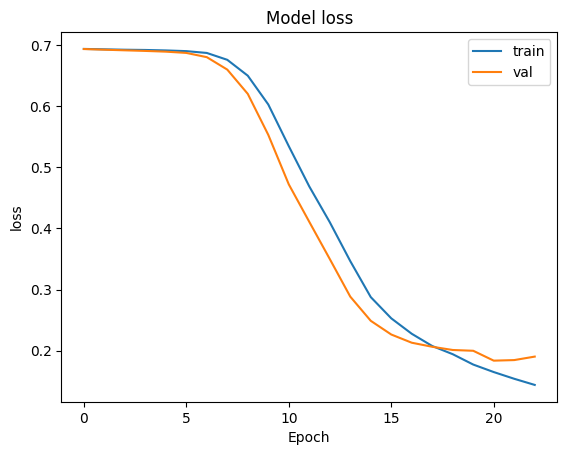

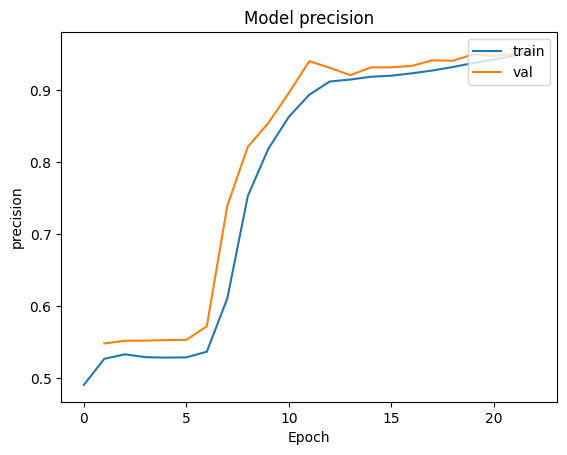

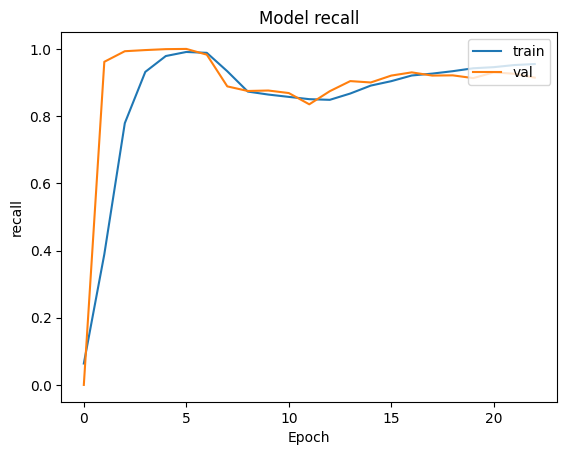

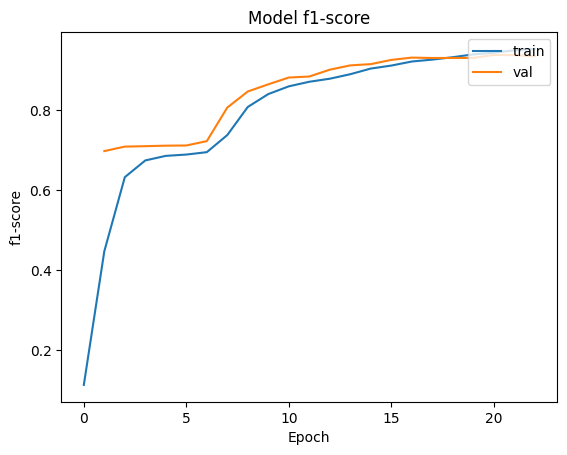

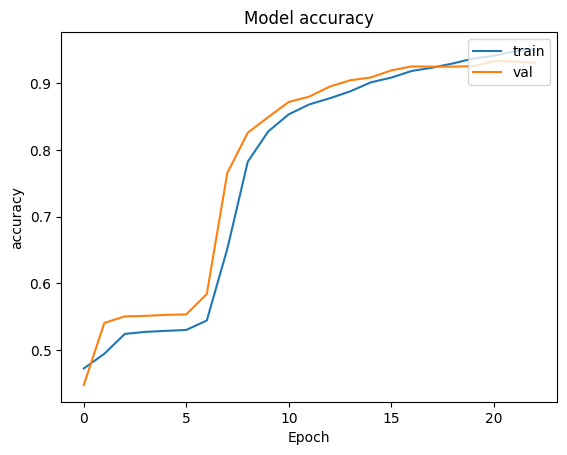

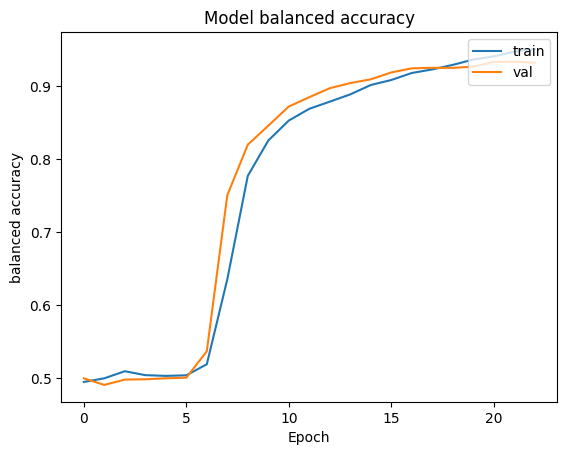

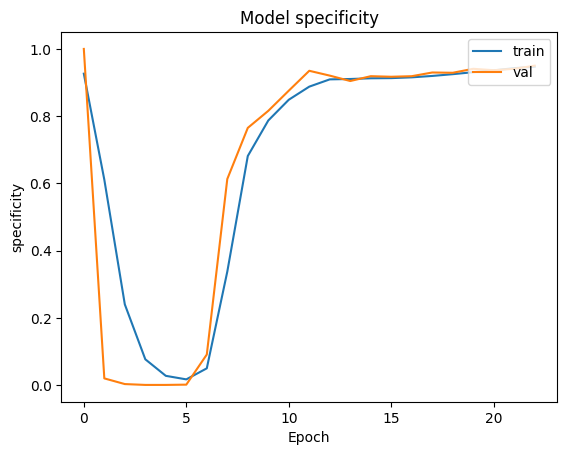

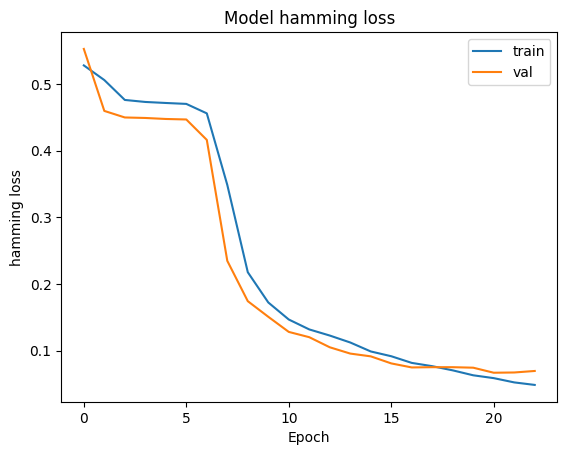

In [28]:
trainer.run()

In [26]:
# from config.Tester import Tester
tester = Tester_level_1(model = model_level_1, weights_file = level_1_model_file, level =1,  data_loader = test_dataloader, checkpoint_dir = level_1_checkpoint_dir)

weights are loaded


In [27]:
tester.prediction()

started prediction
2024-05-31 05:36:57.877827


  0%|          | 0/83 [00:00<?, ?batch/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 83/83 [00:10<00:00,  8.26batch/s, loss=0.166] 

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
LOSS test 0.18692880868911743, test_precision 0.9441379310344827, test_recall 0.9325613079019074, test_f1 0.9383139136394791, test_accuracy 0.9319984888553079, test_BA 0.9319295089127857, test_specificity 0.9312977099236641, test_hamming_loss 0.0680015111446921


Level 2

In [31]:
import gc
# del train_dataloader
# del val_dataloader
# del test_dataloader
del classifier_level_1
del output_layer_level_1
del model_level_1
del trainer
del tester
gc.collect()

17661

In [26]:
used_model = 'bert_final'
no_epoch = 100
lr = 0.0005
optimizer = 'Adadelta'
level_2_checkpoint_dir = '/kaggle/working/checkpoints_pytorch/'+used_model+'/level_2_'
fiction_gamma_pos = 4
fiction_gamma_neg = 5
non_fiction_gamma_pos = 4
non_fiction_gamma_neg = 5

# Check if level_2_checkpoint_dir exists, if not, create it
if not os.path.exists(level_2_checkpoint_dir):
#     os.makedirs(level_2_checkpoint_dir)
    os.makedirs(level_2_checkpoint_dir+'fiction')
    os.makedirs(level_2_checkpoint_dir+'non_fiction')

In [27]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1, model_name = 'bert')
model_level_1 = assign_gpu_model(model_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

cuda


<All keys matched successfully>

In [28]:
def freeze_used_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    # print(model.modules)
    # print(model.fc.in_features)

    modules=list(model.children())[:-2]
    print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_level_1_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    print(model.modules)
    # print(model.fc.in_features)

    modules=list(model.children())[:-1]
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_full_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    print(model.modules)
    # print(model.fc.in_features)

    modules=list(model.children())
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

In [29]:
import copy
used_model = freeze_used_model(copy.deepcopy(model_level_1))

[BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [30]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1, model_name = 'bert')
model_level_1.load_state_dict(torch.load(level_1_weights_path))
model_level_1 = assign_gpu_model(model_level_1)

FE_model_level_1 = freeze_level_1_model(copy.deepcopy(model_level_1))

cuda
<bound method Module.modules of level_1_model(
  (pre_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [31]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1, model_name = 'bert')
model_level_1.load_state_dict(torch.load(level_1_weights_path))
model_level_1 = assign_gpu_model(model_level_1)

model_level_1 = freeze_full_model(copy.deepcopy(model_level_1))

cuda
<bound method Module.modules of level_1_model(
  (pre_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [32]:
fiction_classifier = level_2_classifier(model_feature_size = used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class = 29)
fiction_model = level_2_post_model(level_2_classifier = fiction_classifier, level_2_output_layer = fiction_op_layer)
fiction_model = assign_gpu_model(fiction_model)

cuda


In [33]:
non_fiction_classifier = level_2_classifier(model_feature_size = used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
non_fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class = 29)
non_fiction_model = level_2_post_model(level_2_classifier = non_fiction_classifier, level_2_output_layer = non_fiction_op_layer)
non_fiction_model = assign_gpu_model(non_fiction_model)

cuda


In [34]:
level_2_pre_model = level_2_pre_model_concate(used_model, FE_model_level_1)

In [35]:
level_2_pre_model

level_2_pre_model_concate(
  (used_model): Sequential(
    (0): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [36]:
level_2_trainer = Trainer_level_2(level_1_model = model_level_1, level_2_pre_model = level_2_pre_model, fiction_model =  fiction_model, non_fiction_model = non_fiction_model, training_dataloader = train_dataloader, validation_dataloader = val_dataloader, epoch = no_epoch, learning_rate = lr, use_gpu = True, opt_method = optimizer, fiction_checkpoint_dir = level_2_checkpoint_dir+'fiction', non_fiction_checkpoint_dir = level_2_checkpoint_dir+'non_fiction', checkpoint_filename = level_1_model_file, fiction_gamma_pos = fiction_gamma_pos, fiction_gamma_neg = fiction_gamma_neg, non_fiction_gamma_pos = non_fiction_gamma_pos, non_fiction_gamma_neg = non_fiction_gamma_neg, csv_logger = level_1_csvlogger_file)

In [ ]:
level_2_trainer.run()

In [ ]:
tester_level_2 = Tester_level_2(level_1_model = model_level_1, level_2_pre_model = level_2_pre_model, fiction_model =  fiction_model, non_fiction_model = non_fiction_model, weights_file = level_1_model_file, data_loader = test_dataloader, fiction_checkpoint_dir = level_2_checkpoint_dir+'fiction', non_fiction_checkpoint_dir = level_2_checkpoint_dir+'non_fiction', fiction_gamma_pos = fiction_gamma_pos, fiction_gamma_neg = fiction_gamma_neg, non_fiction_gamma_pos = non_fiction_gamma_pos, non_fiction_gamma_neg = non_fiction_gamma_neg)

In [ ]:
tester_level_2.prediction()